### segmentation label이 왜곡돼서 나타나는 이유

- labeling의 문제가 아니었음
- 전처리의 resampling 과정에서 label 이미지의 Resolution이 떨어지는 듯함

<이유>

- **추측 1. 300x300x300으로 바꾼 파일의 문제**: 얘가 맞았음
    - 새롭게 알게 된 사실: torchio로 일괄적으로 CropOrPad가 안 됨 => resampled 이미지를 미리 저장하면 해결
- 추측 2. torchio 버그

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

In [2]:
import numpy as np
import nibabel as nib
import pandas as pd
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchio as tio
from models.segmentation import *
from models.sfcn import *
from models.pretrained_cnn import *
from models.vnet_regressor import *
from models.sfcn_fds import *
from models.pretrained_cnn_fds import *
from models.lds_utils import get_lds_kernel_window
from models.loss import weighted_focal_mse_loss, weighted_focal_l1_loss
from collections import Counter
from scipy.ndimage import zoom, convolve1d, rotate
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import gc
import wandb

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Sun Jun 18 23:25:04 2023
TorchIO version: 0.18.83


In [4]:
RANDOM_SEED = 551

In [5]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Count of using GPUs: 2


### 데이터로더

In [7]:
def prepare_dataset(image_dir='./input_nifti/', label_dir='./input_nifti_seg/'):
        # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
    filenames = sorted(os.listdir(label_dir))  # image_dir랑 label_dir에 저장되어있는 파일명이 같음
#     print(filenames)

    subjects = []
    for filename in tqdm(filenames):
        subject = tio.Subject(
            img = tio.ScalarImage(image_dir + filename),
            label = tio.LabelMap(label_dir + filename))   # label => LabelMap!!!!!!!
        subjects.append(subject)
    dataset = tio.SubjectsDataset(subjects)
    return subjects, dataset

In [8]:
def run_training(net_seg):
    running_seg_loss = 0.0
    running_seg_score = 0.0

    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']

#         print('before')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()

        
#         print('labels:', labels[0,0,:,:,labels.shape[4]//2])
        
#         l1=(labels==1)
#         l0=(labels==0)
#         labels = torch.cat((l0,l1),1)
        
#         print('after')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()
#         plt.imshow(labels[0,1,:,:,labels.shape[4]//2])
#         plt.show()
#         break

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)
#         if (i % effective_batchsize) == 0:
        optimizer_seg.zero_grad()
        
        net_seg.train()
        outputs_seg = net_seg(inputs)

        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
#         ##
#         print('input:',outputs_seg.shape,'target:', labels.shape)
        loss_seg, score_seg = criterion_seg(outputs_seg, labels)

        loss_seg.backward()
        optimizer_seg.step()

        running_seg_loss += loss_seg.detach().cpu().item()
        running_seg_score += score_seg.detach().cpu().item()
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_loss = running_seg_loss / len(train_loader)
    avg_score = running_seg_score / len(train_loader)
    
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    
    return avg_loss, avg_score, one_output_seg, one_output_img, one_output_lbl

In [9]:
def run_validation(net_seg):
    net_seg.eval()
  
    running_seg_loss = 0.0
    running_seg_score = 0.0
    
    total_output_seg=[]
    total_output_img=[]
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    
            
#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)
            
            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)
            
            net_seg.eval()
            
            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())
            
            outputs_seg = net_seg(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())
            
            loss_seg, score_seg = criterion_seg(outputs_seg, labels)
            
            running_seg_loss += loss_seg.detach().cpu().item()
            running_seg_score += score_seg.detach().cpu().item()
            
    avg_loss = running_seg_loss / len(valid_loader)
    avg_score = running_seg_score / len(valid_loader)
    
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)

    return avg_loss, avg_score, one_output_seg, one_output_img, one_output_lbl, total_output_seg, total_output_img

In [10]:
image_dir = './input_nifti_sizematch/'
label_dir = './input_nifti_seg_sizematch/'
subjects, dataset = prepare_dataset(image_dir, label_dir)

100%|██████████████████████████████████████| 129/129 [00:00<00:00, 17366.88it/s]


In [11]:
print('Dataset size : ', len(dataset), 'subjects')

Dataset size :  129 subjects


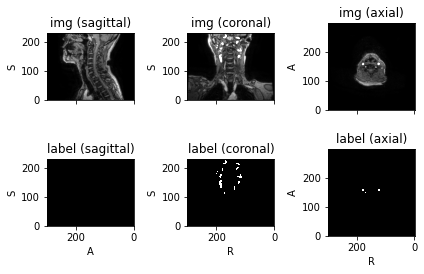

In [12]:
## 데이터셋 확인
for training_instance in dataset:
    training_instance.plot()  # SubjectDataset
    break

In [13]:
set_seed()

w, h, d = 300, 300, 232  # w=LR / h=AP / d=SI
img_size = 192  # [16,32,48,64,80,96,112,128,144,160, 176,192,208,224]
sample_w = w / img_size
sample_h = h / img_size
sample_d = d / img_size

# transformation
preprocess = tio.Compose([
    tio.CropOrPad((w,h,d)),
    tio.Resample((sample_w, sample_h, sample_d)),
#     tio.Resample(1.5),
#     tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
#     tio.OneHot(),
])

# data set
dataset = tio.SubjectsDataset(subjects, transform=preprocess)

In [14]:
# filenames = sorted(os.listdir(label_dir))
# error_file = []
# for i, data in enumerate(dataset):
#     try:
#         print("No. {}: {}".format(i+1, filenames[i]))
#         print(data['img'])
#         print(data['label'])
#         print()
#     except Exception:
#         error_file.append(filenames[i])

(1, 192, 192, 192)


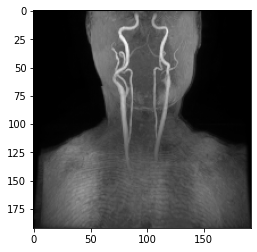

(1, 192, 192, 192)


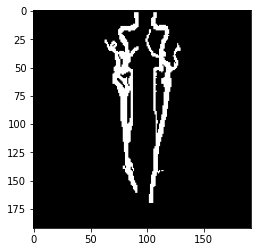

In [15]:
## 전처리된 데이터셋 확인
img = dataset[0]['img'].numpy()
label = dataset[0]['label'].numpy()
print(img.shape)
plt.imshow(rotate(np.max(img[0], axis=1), 90), cmap='gray')
plt.show()
print(label.shape)
plt.imshow(rotate(np.max(label[0], axis=1), 90), cmap='gray')
plt.show()

In [16]:
# ## 모델 확인
# normalization = 'groupnorm'
# net_seg = VNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization)
# net_seg

In [18]:
set_seed()
batch_size = 6
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=False)

### segmentation 학습 (n=130)

V-Net-1 Training Start


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


100%|███████████████████████████████████████████| 22/22 [00:54<00:00,  2.47s/it]


# EPOCH 1 / 10
Train


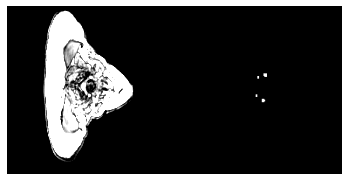

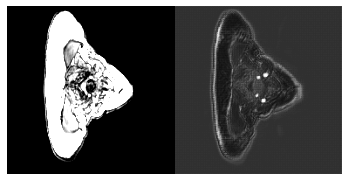

100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.35s/it]


# EPOCH 2 / 10


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.40s/it]


# EPOCH 3 / 10


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.41s/it]


# EPOCH 4 / 10


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.40s/it]


# EPOCH 5 / 10


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.38s/it]


# EPOCH 6 / 10
Train


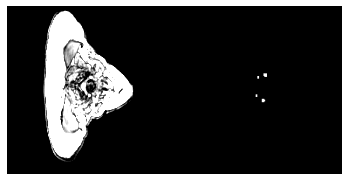

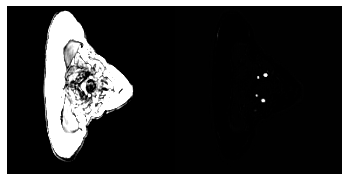

100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.44s/it]


# EPOCH 7 / 10


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.44s/it]


# EPOCH 8 / 10


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.41s/it]


# EPOCH 9 / 10


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.34s/it]


# EPOCH 10 / 10


train_loss,█▇▅▂▁▁▁▁▁▁
train_score,▁▂▄▇██████
train_loss,0.60757
train_score,0.39243


V-Net-2 Training Start


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.39s/it]


# EPOCH 1 / 10
Train


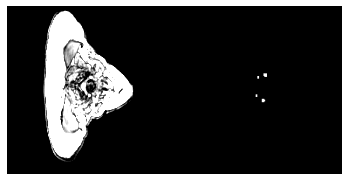

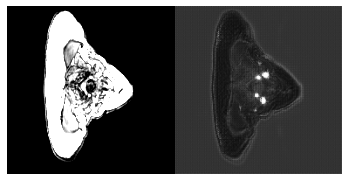

100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.36s/it]


# EPOCH 2 / 10


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.53s/it]


# EPOCH 3 / 10


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.43s/it]


# EPOCH 4 / 10


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.44s/it]


# EPOCH 5 / 10


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.43s/it]


# EPOCH 6 / 10
Train


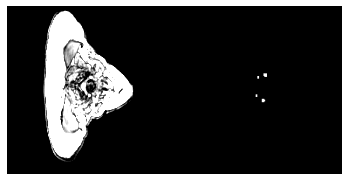

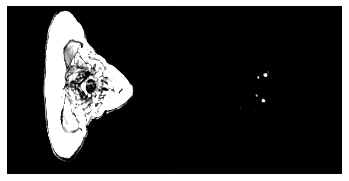

100%|███████████████████████████████████████████| 22/22 [00:54<00:00,  2.50s/it]


# EPOCH 7 / 10


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.51s/it]


# EPOCH 8 / 10


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.43s/it]


# EPOCH 9 / 10


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.51s/it]


# EPOCH 10 / 10


train_loss,█▇▅▂▁▁▁▁▁▁
train_score,▁▂▄▇██████
train_loss,0.60111
train_score,0.39889


V-Net-3 Training Start


100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.82s/it]


# EPOCH 1 / 10
Train


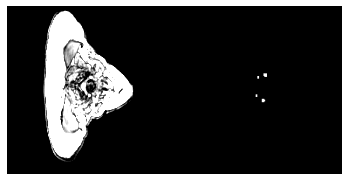

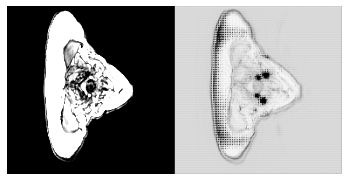

100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.85s/it]


# EPOCH 2 / 10


100%|███████████████████████████████████████████| 22/22 [00:59<00:00,  2.72s/it]


# EPOCH 3 / 10


100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.86s/it]


# EPOCH 4 / 10


100%|███████████████████████████████████████████| 22/22 [01:00<00:00,  2.76s/it]


# EPOCH 5 / 10


100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.82s/it]


# EPOCH 6 / 10
Train


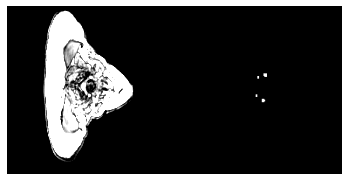

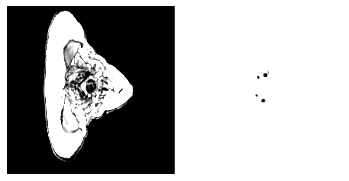

100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.82s/it]


# EPOCH 7 / 10


100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.86s/it]


# EPOCH 8 / 10


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.91s/it]


# EPOCH 9 / 10


100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.82s/it]


# EPOCH 10 / 10


train_loss,█▇▄▂▁▁▁▁▁▁
train_score,▁▂▅▇██████
train_loss,0.59099
train_score,0.40901


V-Net-4 Training Start


100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.85s/it]


# EPOCH 1 / 10
Train


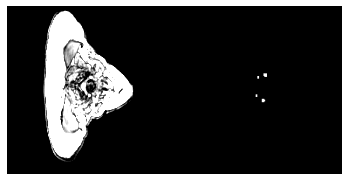

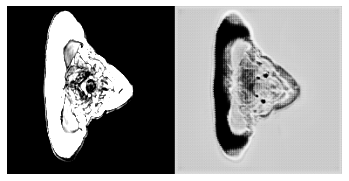

100%|███████████████████████████████████████████| 22/22 [01:05<00:00,  2.99s/it]


# EPOCH 2 / 10


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.87s/it]


# EPOCH 3 / 10


100%|███████████████████████████████████████████| 22/22 [01:04<00:00,  2.92s/it]


# EPOCH 4 / 10


100%|███████████████████████████████████████████| 22/22 [01:04<00:00,  2.92s/it]


# EPOCH 5 / 10


100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.79s/it]


# EPOCH 6 / 10
Train


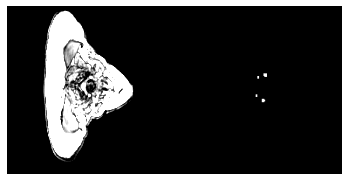

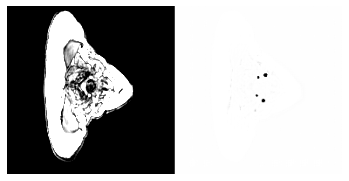

100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.89s/it]


# EPOCH 7 / 10


100%|███████████████████████████████████████████| 22/22 [01:05<00:00,  2.96s/it]


# EPOCH 8 / 10


100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.83s/it]


# EPOCH 9 / 10


100%|███████████████████████████████████████████| 22/22 [01:05<00:00,  2.96s/it]


# EPOCH 10 / 10


train_loss,██▇▄▂▁▁▁▁▁
train_score,▁▁▂▅▇█████
train_loss,0.59577
train_score,0.40423


In [20]:
normalization = 'groupnorm'
num_epochs = 10
lr = 0.001
optim_class = optim.Adam

for blocknum in range(1,5):
    print("V-Net-{} Training Start".format(blocknum))

    set_seed()
    net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
    net_seg.cuda()

    wandb.init(
        project='202303-segmentation',
        config={"model": "VNet-%d"%blocknum, "input_size": img_size,
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
    wandb.watch(net_seg)

    train_losses = []
    #     validation_losses = []

    S = img_size // 2

    #     min_valid_loss = 1.0
    min_loss = 1.0

    optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
    criterion_seg = DiceLoss()
    # criterion_seg = GeneralizedDiceLoss()
    # scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

    set_seed()
    for epoch in range(num_epochs):
        train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
    #         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
        print('# EPOCH %d / %d'%(epoch+1, num_epochs))
        train_losses.append(train_loss)
    #         validation_losses.append(valid_loss)

        train_img = wandb.Image(train_img_part[0,:,:,S])
        train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
        train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
    #         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
    #         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
    #         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

    #         if min_valid_loss > valid_loss:
    #             min_valid_loss = valid_loss
    #             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
        if min_loss > train_loss:
            min_loss = train_loss
            torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best3'.format(blocknum, img_size))        

        lbl_train = train_input_lbl[0, :, : ,S]
        seg_train = train_seg_part[0, :, : , S]
    #     lbl_valid = valid_input_lbl_part[0, :, : , S]
    #     seg_valid = valid_output_seg_part[0, :, : , S]


        if epoch%5==0:
            print('Train')
    #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
            plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
            plt.axis("off")
            plt.show()

    #         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
            plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
            plt.axis("off")
            plt.show()

    #             print('Valid')
    #     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
    #             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
    #             plt.show()  
    #     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
    #             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
    #             plt.show()

    #             # loss curve
    #             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
    #             red_patch = mpatches.Patch(color='red', label='Validation')
    #             blue_patch = mpatches.Patch(color='blue', label='Training')
    #             plt.legend(handles=[red_patch, blue_patch])
    #             plt.show()


        wandb.log({"train_loss": train_loss, "train_score": train_score,
                   "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
    wandb.finish()

In [22]:
for blocknum in range(4, 0, -1):
    # Evaluation
    text = "-------------------------------------------------------------------------------\n"
    text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
    text += "===============================================================================\n"

    normalization = 'groupnorm'
    criterion = SegMetrics()

    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best3'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    running_pa = 0.0
    running_dice = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_spec = 0.0

    total_output_seg=[]
    total_output_img=[]

    with torch.no_grad():
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())

            outputs_seg = (outputs_seg >= 0.5).float()  # 확률값 => 0, 1로
            pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

            running_pa += pixel_acc.detach().cpu().item()
            running_dice += dice.detach().cpu().item()
            running_prec += precision.detach().cpu().item()
            running_rec += recall.detach().cpu().item()
            running_spec += specificity.detach().cpu().item()

    avg_pa = running_pa / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_prec = running_prec / len(train_loader)
    avg_rec = running_rec / len(train_loader)
    avg_spec = running_spec / len(train_loader)

    text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
    text += "===============================================================================\n"
    print(text)

100%|███████████████████████████████████████████| 22/22 [00:32<00:00,  1.48s/it]


-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-4	0.500	0.395	0.419	0.500	0.500



100%|███████████████████████████████████████████| 22/22 [00:33<00:00,  1.54s/it]


-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-3	0.500	0.401	0.420	0.500	0.500



100%|███████████████████████████████████████████| 22/22 [00:32<00:00,  1.49s/it]


-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-2	0.500	0.387	0.438	0.500	0.500



100%|███████████████████████████████████████████| 22/22 [00:32<00:00,  1.49s/it]

-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-1	0.500	0.384	0.412	0.500	0.500



  0%|                                                    | 0/22 [00:31<?, ?it/s]


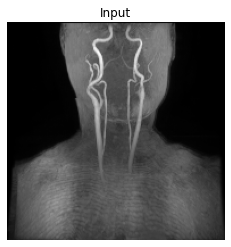

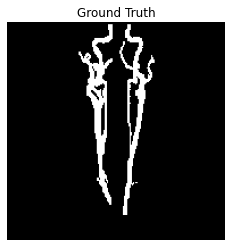

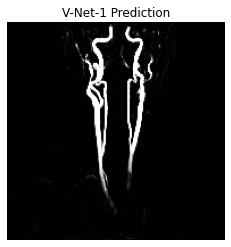

  0%|                                                    | 0/22 [00:25<?, ?it/s]


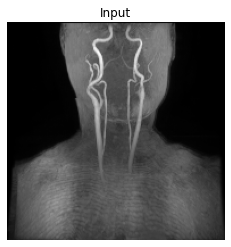

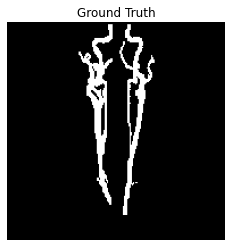

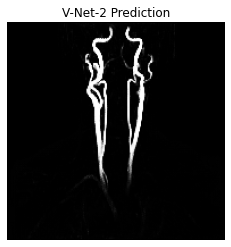

  0%|                                                    | 0/22 [00:32<?, ?it/s]


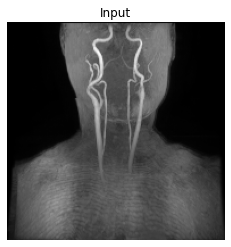

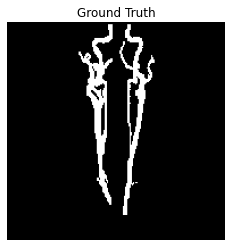

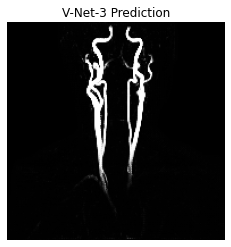

  0%|                                                    | 0/22 [00:31<?, ?it/s]


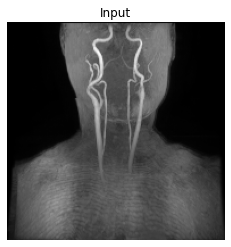

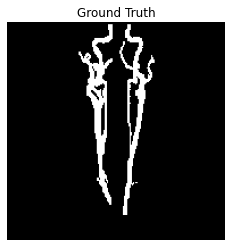

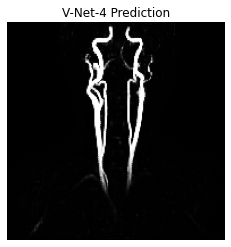

In [24]:
# Evaluation (예시 이미지): 새로 labeling 해서 학습한 모델
for blocknum in range(1, 5):
    normalization = 'groupnorm'

    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best3'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    with torch.no_grad():
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
            break

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]

    img_in = one_output_img[0]
    img_gt = one_output_lbl[0]
    if blocknum < 3:
        img_p = one_output_seg[1]
    else:
        img_p = one_output_seg[0]

    # scale = 300 / img_size
    # img_in = zoom(img_in, (scale, scale, scale))
    # img_gt = zoom(img_gt[0], (scale, scale, scale))
    # img_p = zoom(img_p[1], (scale, scale, scale))

    plt.title("Input")
    plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("Ground Truth")
    plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("V-Net-{} Prediction".format(blocknum))
    plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

### V-Net-1

In [17]:
blocknum = 1
normalization = 'groupnorm'
num_epochs = 50
lr = 0.001
optim_class = optim.Adam
batch_size = 6

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.44s/it]


# EPOCH 1 / 50
Train


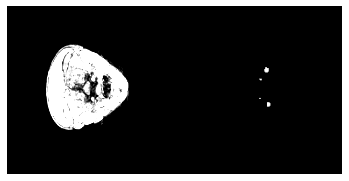

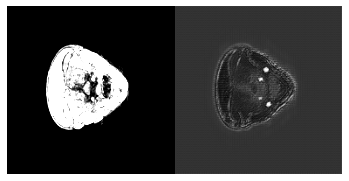

100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.35s/it]


# EPOCH 2 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.31s/it]


# EPOCH 3 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.28s/it]


# EPOCH 4 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.37s/it]


# EPOCH 5 / 50


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.43s/it]


# EPOCH 6 / 50
Train


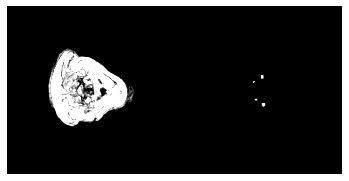

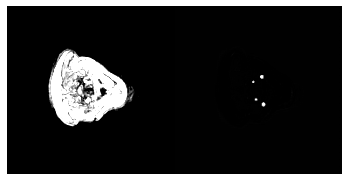

100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.39s/it]


# EPOCH 7 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.32s/it]


# EPOCH 8 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.35s/it]


# EPOCH 9 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.37s/it]


# EPOCH 10 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.36s/it]


# EPOCH 11 / 50
Train


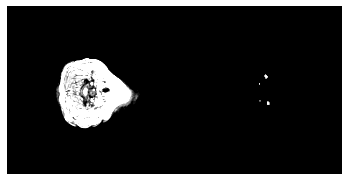

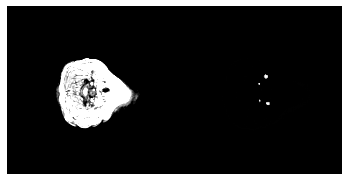

100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.38s/it]


# EPOCH 12 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.29s/it]


# EPOCH 13 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.31s/it]


# EPOCH 14 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.37s/it]


# EPOCH 15 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.37s/it]


# EPOCH 16 / 50
Train


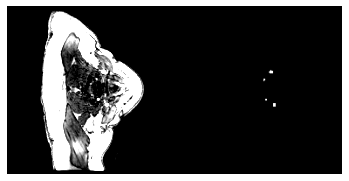

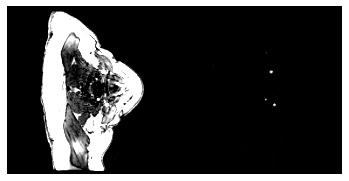

100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.39s/it]


# EPOCH 17 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.34s/it]


# EPOCH 18 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.36s/it]


# EPOCH 19 / 50


100%|███████████████████████████████████████████| 22/22 [00:53<00:00,  2.45s/it]


# EPOCH 20 / 50


100%|███████████████████████████████████████████| 22/22 [00:54<00:00,  2.50s/it]


# EPOCH 21 / 50
Train


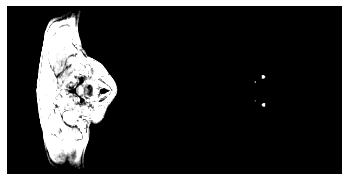

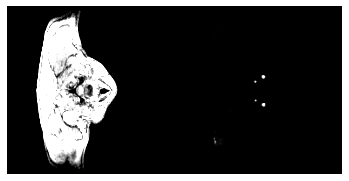

100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.31s/it]


# EPOCH 22 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.39s/it]


# EPOCH 23 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.31s/it]


# EPOCH 24 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.32s/it]


# EPOCH 25 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.33s/it]


# EPOCH 26 / 50
Train


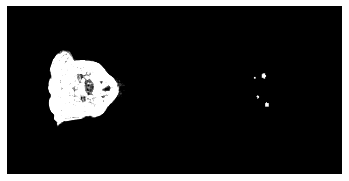

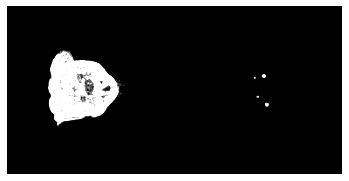

100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.33s/it]


# EPOCH 27 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.37s/it]


# EPOCH 28 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.30s/it]


# EPOCH 29 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.30s/it]


# EPOCH 30 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.41s/it]


# EPOCH 31 / 50
Train


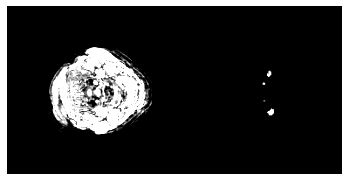

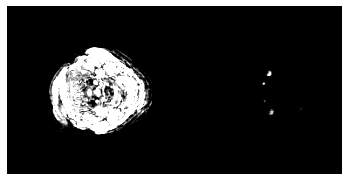

100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.33s/it]


# EPOCH 32 / 50


100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.37s/it]


# EPOCH 33 / 50


100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.31s/it]


# EPOCH 34 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.35s/it]


# EPOCH 35 / 50


100%|███████████████████████████████████████████| 22/22 [00:51<00:00,  2.36s/it]


# EPOCH 36 / 50
Train


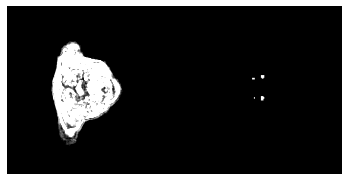

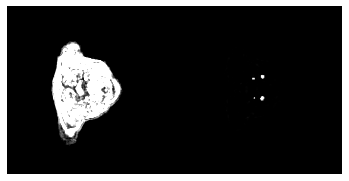

100%|███████████████████████████████████████████| 22/22 [00:52<00:00,  2.37s/it]


# EPOCH 37 / 50


  0%|                                                    | 0/22 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [18]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

In [19]:
wandb.finish()

train_loss,██▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▁▃▆▇▇███████████████████████████████
train_loss,0.59206
train_score,0.40794


In [20]:
# Evaluation
text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

blocknum = 1
normalization = 'groupnorm'
criterion = SegMetrics()

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

running_pa = 0.0
running_dice = 0.0
running_prec = 0.0
running_rec = 0.0
running_spec = 0.0

total_output_seg=[]
total_output_img=[]

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        total_inputs=copy.deepcopy(inputs)
        total_output_img.append(total_inputs.detach().cpu().numpy())

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
        total_outputs=copy.deepcopy(outputs_seg)
        total_output_seg.append(total_outputs.detach().cpu().numpy())

        outputs_seg = (outputs_seg >= 0.5).float()  # 확률값 => 0, 1로
        pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

        running_pa += pixel_acc.detach().cpu().item()
        running_dice += dice.detach().cpu().item()
        running_prec += precision.detach().cpu().item()
        running_rec += recall.detach().cpu().item()
        running_spec += specificity.detach().cpu().item()

avg_pa = running_pa / len(train_loader)
avg_dice = running_dice / len(train_loader)
avg_prec = running_prec / len(train_loader)
avg_rec = running_rec / len(train_loader)
avg_spec = running_spec / len(train_loader)

text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
text += "===============================================================================\n"
print(text)

100%|███████████████████████████████████████████| 22/22 [00:32<00:00,  1.50s/it]

-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-1	0.500	0.394	0.411	0.500	0.500



  0%|                                                    | 0/22 [00:32<?, ?it/s]


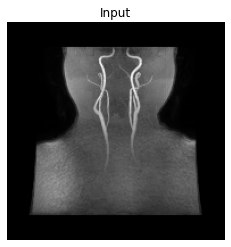

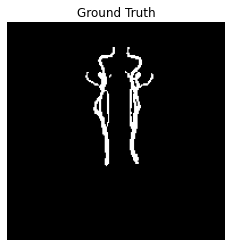

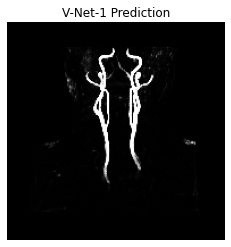

In [21]:
# Evaluation (예시 이미지): 새로 labeling 해서 학습한 모델
blocknum = 1
normalization = 'groupnorm'

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
        break

one_output_seg = outputs_seg.detach().cpu().numpy()[0]
one_output_img = inputs.detach().cpu().numpy()[0]
one_output_lbl = labels.detach().cpu().numpy()[0]

img_in = one_output_img[0]
img_gt = one_output_lbl[0]
img_p = one_output_seg[1]

# scale = 300 / img_size
# img_in = zoom(img_in, (scale, scale, scale))
# img_gt = zoom(img_gt[0], (scale, scale, scale))
# img_p = zoom(img_p[1], (scale, scale, scale))

plt.title("Input")
plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("Ground Truth")
plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("V-Net-{} Prediction".format(blocknum))
plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

### V-Net-2

In [22]:
blocknum = 2
normalization = 'groupnorm'
num_epochs = 15
lr = 0.001
optim_class = optim.Adam
batch_size = 6

100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.78s/it]

# EPOCH 1 / 15
Train


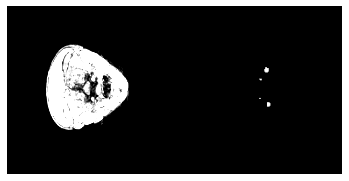

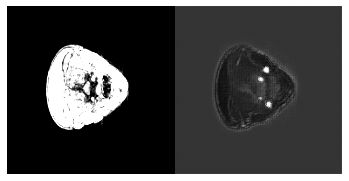

100%|███████████████████████████████████████████| 22/22 [00:57<00:00,  2.63s/it]


# EPOCH 2 / 15


100%|███████████████████████████████████████████| 22/22 [01:00<00:00,  2.77s/it]


# EPOCH 3 / 15


100%|███████████████████████████████████████████| 22/22 [00:59<00:00,  2.72s/it]


# EPOCH 4 / 15


100%|███████████████████████████████████████████| 22/22 [00:56<00:00,  2.59s/it]


# EPOCH 5 / 15


100%|███████████████████████████████████████████| 22/22 [01:00<00:00,  2.73s/it]

# EPOCH 6 / 15
Train


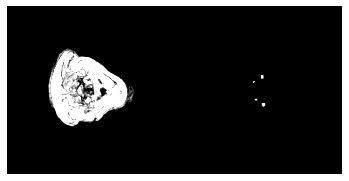

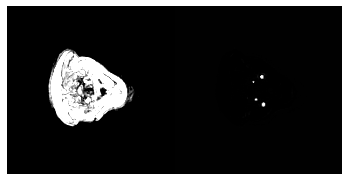

100%|███████████████████████████████████████████| 22/22 [00:56<00:00,  2.55s/it]


# EPOCH 7 / 15


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.53s/it]


# EPOCH 8 / 15


100%|███████████████████████████████████████████| 22/22 [01:01<00:00,  2.78s/it]


# EPOCH 9 / 15


100%|███████████████████████████████████████████| 22/22 [00:58<00:00,  2.66s/it]


# EPOCH 10 / 15


100%|███████████████████████████████████████████| 22/22 [00:56<00:00,  2.57s/it]

# EPOCH 11 / 15
Train


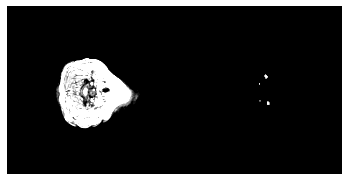

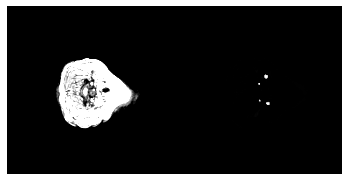

100%|███████████████████████████████████████████| 22/22 [00:57<00:00,  2.60s/it]


# EPOCH 12 / 15


100%|███████████████████████████████████████████| 22/22 [00:55<00:00,  2.51s/it]


# EPOCH 13 / 15


100%|███████████████████████████████████████████| 22/22 [00:57<00:00,  2.63s/it]


# EPOCH 14 / 15


100%|███████████████████████████████████████████| 22/22 [00:56<00:00,  2.56s/it]


# EPOCH 15 / 15


train_loss,██▆▃▂▁▁▁▁▁▁▁▁▁▁
train_score,▁▁▃▆▇██████████
train_loss,0.58519
train_score,0.41481


In [23]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

In [24]:
# Evaluation
text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

blocknum = 2
normalization = 'groupnorm'
criterion = SegMetrics()

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

running_pa = 0.0
running_dice = 0.0
running_prec = 0.0
running_rec = 0.0
running_spec = 0.0

total_output_seg=[]
total_output_img=[]

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        total_inputs=copy.deepcopy(inputs)
        total_output_img.append(total_inputs.detach().cpu().numpy())

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
        total_outputs=copy.deepcopy(outputs_seg)
        total_output_seg.append(total_outputs.detach().cpu().numpy())

        outputs_seg = (outputs_seg >= 0.5).float()  # 확률값 => 0, 1로
        pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

        running_pa += pixel_acc.detach().cpu().item()
        running_dice += dice.detach().cpu().item()
        running_prec += precision.detach().cpu().item()
        running_rec += recall.detach().cpu().item()
        running_spec += specificity.detach().cpu().item()

avg_pa = running_pa / len(train_loader)
avg_dice = running_dice / len(train_loader)
avg_prec = running_prec / len(train_loader)
avg_rec = running_rec / len(train_loader)
avg_spec = running_spec / len(train_loader)

text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
text += "===============================================================================\n"
print(text)

100%|███████████████████████████████████████████| 22/22 [00:32<00:00,  1.48s/it]

-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-2	0.500	0.393	0.447	0.500	0.500



  0%|                                                    | 0/22 [00:30<?, ?it/s]


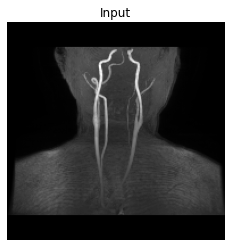

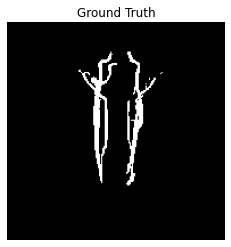

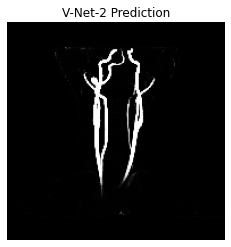

In [25]:
# Evaluation (예시 이미지): 새로 labeling 해서 학습한 모델
blocknum = 2
normalization = 'groupnorm'

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
        break

one_output_seg = outputs_seg.detach().cpu().numpy()[0]
one_output_img = inputs.detach().cpu().numpy()[0]
one_output_lbl = labels.detach().cpu().numpy()[0]

img_in = one_output_img[0]
img_gt = one_output_lbl[0]
img_p = one_output_seg[1]

# scale = 300 / img_size
# img_in = zoom(img_in, (scale, scale, scale))
# img_gt = zoom(img_gt[0], (scale, scale, scale))
# img_p = zoom(img_p[1], (scale, scale, scale))

plt.title("Input")
plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("Ground Truth")
plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("V-Net-{} Prediction".format(blocknum))
plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

### V-Net-3

In [26]:
blocknum = 3
normalization = 'groupnorm'
num_epochs = 15
lr = 0.001
optim_class = optim.Adam
batch_size = 6

100%|███████████████████████████████████████████| 22/22 [01:04<00:00,  2.92s/it]


# EPOCH 1 / 15
Train


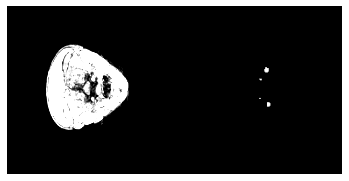

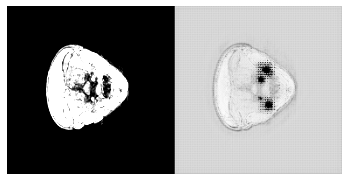

100%|███████████████████████████████████████████| 22/22 [01:04<00:00,  2.95s/it]


# EPOCH 2 / 15


100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.85s/it]


# EPOCH 3 / 15


100%|███████████████████████████████████████████| 22/22 [01:04<00:00,  2.93s/it]


# EPOCH 4 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.89s/it]


# EPOCH 5 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.90s/it]


# EPOCH 6 / 15
Train


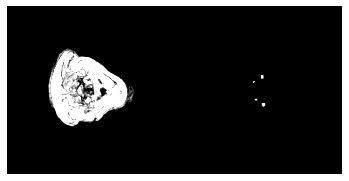

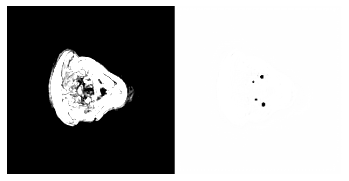

100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.90s/it]


# EPOCH 7 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.88s/it]


# EPOCH 8 / 15


100%|███████████████████████████████████████████| 22/22 [01:05<00:00,  2.99s/it]


# EPOCH 9 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.87s/it]


# EPOCH 10 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.90s/it]


# EPOCH 11 / 15
Train


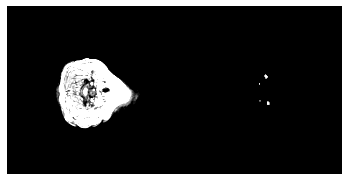

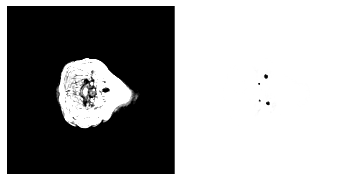

100%|███████████████████████████████████████████| 22/22 [01:02<00:00,  2.85s/it]


# EPOCH 12 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.90s/it]


# EPOCH 13 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.90s/it]


# EPOCH 14 / 15


100%|███████████████████████████████████████████| 22/22 [01:03<00:00,  2.89s/it]


# EPOCH 15 / 15


train_loss,█▇▅▂▂▁▁▁▁▁▁▁▁▁▁
train_score,▁▂▄▇▇██████████
train_loss,0.58067
train_score,0.41933


In [27]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

In [28]:
# Evaluation
text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

blocknum = 3
normalization = 'groupnorm'
criterion = SegMetrics()

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

running_pa = 0.0
running_dice = 0.0
running_prec = 0.0
running_rec = 0.0
running_spec = 0.0

total_output_seg=[]
total_output_img=[]

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        total_inputs=copy.deepcopy(inputs)
        total_output_img.append(total_inputs.detach().cpu().numpy())

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
        total_outputs=copy.deepcopy(outputs_seg)
        total_output_seg.append(total_outputs.detach().cpu().numpy())

        outputs_seg = (outputs_seg >= 0.5).float()  # 확률값 => 0, 1로
        pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

        running_pa += pixel_acc.detach().cpu().item()
        running_dice += dice.detach().cpu().item()
        running_prec += precision.detach().cpu().item()
        running_rec += recall.detach().cpu().item()
        running_spec += specificity.detach().cpu().item()

avg_pa = running_pa / len(train_loader)
avg_dice = running_dice / len(train_loader)
avg_prec = running_prec / len(train_loader)
avg_rec = running_rec / len(train_loader)
avg_spec = running_spec / len(train_loader)

text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
text += "===============================================================================\n"
print(text)

100%|███████████████████████████████████████████| 22/22 [00:33<00:00,  1.50s/it]

-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-3	0.500	0.395	0.450	0.500	0.500



  0%|                                                    | 0/22 [00:30<?, ?it/s]


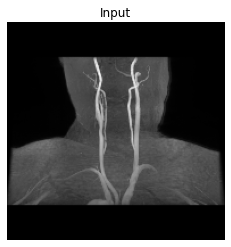

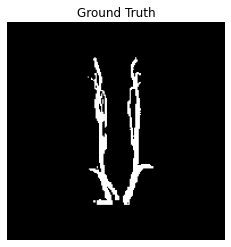

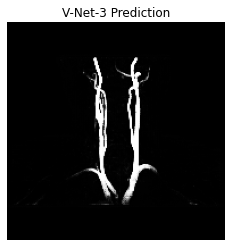

In [30]:
# Evaluation (예시 이미지): 새로 labeling 해서 학습한 모델
blocknum = 3
normalization = 'groupnorm'

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
        break

one_output_seg = outputs_seg.detach().cpu().numpy()[0]
one_output_img = inputs.detach().cpu().numpy()[0]
one_output_lbl = labels.detach().cpu().numpy()[0]

img_in = one_output_img[0]
img_gt = one_output_lbl[0]
img_p = one_output_seg[0]

# scale = 300 / img_size
# img_in = zoom(img_in, (scale, scale, scale))
# img_gt = zoom(img_gt[0], (scale, scale, scale))
# img_p = zoom(img_p[1], (scale, scale, scale))

plt.title("Input")
plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("Ground Truth")
plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("V-Net-{} Prediction".format(blocknum))
plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

### V-Net-4 (V-Net)

In [31]:
blocknum = 4
normalization = 'groupnorm'
num_epochs = 15
lr = 0.001
optim_class = optim.Adam
batch_size = 6

100%|███████████████████████████████████████████| 22/22 [01:05<00:00,  2.97s/it]


# EPOCH 1 / 15
Train


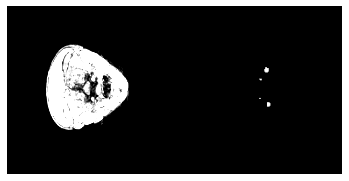

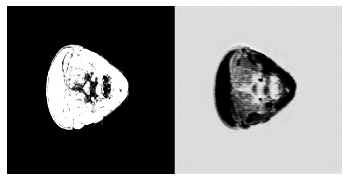

  0%|                                                    | 0/22 [00:00<?, ?it/s]

In [ ]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

In [33]:
# Evaluation
text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

blocknum = 4
normalization = 'groupnorm'
criterion = SegMetrics()

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

running_pa = 0.0
running_dice = 0.0
running_prec = 0.0
running_rec = 0.0
running_spec = 0.0

total_output_seg=[]
total_output_img=[]

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        total_inputs=copy.deepcopy(inputs)
        total_output_img.append(total_inputs.detach().cpu().numpy())

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
        total_outputs=copy.deepcopy(outputs_seg)
        total_output_seg.append(total_outputs.detach().cpu().numpy())

        outputs_seg = (outputs_seg >= 0.5).float()  # 확률값 => 0, 1로
        pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

        running_pa += pixel_acc.detach().cpu().item()
        running_dice += dice.detach().cpu().item()
        running_prec += precision.detach().cpu().item()
        running_rec += recall.detach().cpu().item()
        running_spec += specificity.detach().cpu().item()

avg_pa = running_pa / len(train_loader)
avg_dice = running_dice / len(train_loader)
avg_prec = running_prec / len(train_loader)
avg_rec = running_rec / len(train_loader)
avg_spec = running_spec / len(train_loader)

text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
text += "===============================================================================\n"
print(text)

100%|███████████████████████████████████████████| 22/22 [00:31<00:00,  1.44s/it]

-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-4	0.500	0.387	0.450	0.500	0.500



  0%|                                                    | 0/22 [00:24<?, ?it/s]


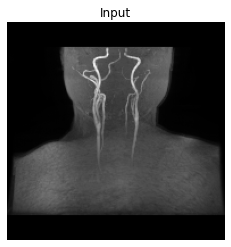

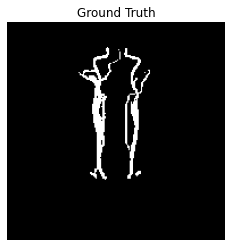

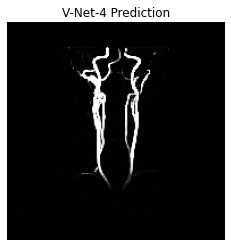

In [34]:
# Evaluation (예시 이미지): 새로 labeling 해서 학습한 모델
blocknum = 4
normalization = 'groupnorm'

net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best2'.format(blocknum, img_size)))
net.cuda()

net.eval()

with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']    

#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        outputs_seg = net(inputs)
        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
        break

one_output_seg = outputs_seg.detach().cpu().numpy()[0]
one_output_img = inputs.detach().cpu().numpy()[0]
one_output_lbl = labels.detach().cpu().numpy()[0]

img_in = one_output_img[0]
img_gt = one_output_lbl[0]
img_p = one_output_seg[0]

# scale = 300 / img_size
# img_in = zoom(img_in, (scale, scale, scale))
# img_gt = zoom(img_gt[0], (scale, scale, scale))
# img_p = zoom(img_p[1], (scale, scale, scale))

plt.title("Input")
plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("Ground Truth")
plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("V-Net-{} Prediction".format(blocknum))
plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

---

### WMH volume Prediction

In [55]:
def load_data(image_dir='./input_nifti_sizematch/', label_dir='labels/data_975.csv', label_name='FL_WMH_VOL_icv'):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for filename in tqdm(filenames):
        img = nib.load(image_dir + filename + '.nii.gz')
        img = img.get_fdata()
        x, y, z = img.shape
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [56]:
image_dir = './input_nifti_sizematch/'  #'./input_nifti/'
label_dir = 'labels/data_975.csv'
label_name = 'FL_WMH_VOL_icv'

In [57]:
X, y = load_data(image_dir, label_dir, label_name)

100%|█████████████████████████████████████████| 975/975 [04:41<00:00,  3.46it/s]


In [58]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
        self.bin_edges = np.histogram_bin_edges(self.y, bins='auto')
        self.weights = self._prepare_weights(lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([self.y[idx]]).astype('float16')
        weight = np.array([self.weights[idx]]).astype('float16') if self.weights is not None else np.asarray([np.float16(1.)])
        return [image, label, weight]
    
    def _prepare_weights(self, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):  
        weights = None
        if lds:
            labels = self.y
            bin_index_per_label = [self._get_bin_idx(label) for label in labels]
            Nb = max(bin_index_per_label) + 1
            num_samples_of_bins = dict(Counter(bin_index_per_label))
            emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

            lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
            eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

            eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
            weights = np.array([np.float32(1 / x) for x in eff_num_per_label]).reshape(labels.shape)
        return weights
    
    def _get_bin_idx(self, label):
        return np.max(np.where(self.bin_edges <= label))

In [61]:
batch_size = 4

In [62]:
# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

w, h, d = 300, 300, 232  # w=LR / h=AP / d=SI
img_size = 192  # [16,32,48,64,80,96,112,128,144,160, 176,192,208,224]
sample_w = w / img_size
sample_h = h / img_size
sample_d = d / img_size

# transformation
preprocess = tio.Compose([
    tio.CropOrPad((w,h,d)),
    tio.Resample((sample_w, sample_h, sample_d)),
    tio.ZNormalization(),
])

# train set
train_set = NeckDataset(X_train, y_train, transform=preprocess, lds=True, lds_ks=100, lds_sigma=20)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

# test set & loader
test_set = NeckDataset(X_test, y_test, transform=preprocess)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

(1, 192, 192, 192)
[1.478]
[0.001675]


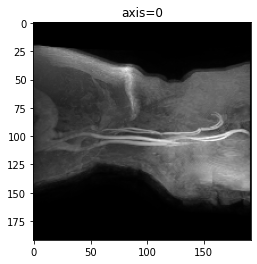

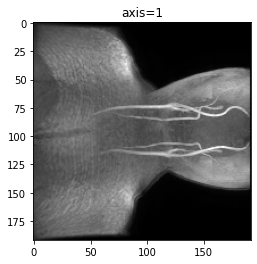

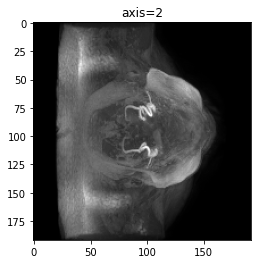

In [63]:
## 데이터셋 확인 (with LDS)
for img, label, weight in train_set:
    print(img.shape)
    print(label)
    print(weight)
    
    img = img.squeeze(0)
    
    plt.title("axis=0")
    plt.imshow(np.max(img, axis=0), cmap='gray')  # axis=0
    plt.show()
    
    plt.title("axis=1")
    plt.imshow(np.max(img, axis=1), cmap='gray')  # axis=1
    plt.show()
    
    plt.title("axis=2")
    plt.imshow(np.max(img, axis=2), cmap='gray')  # axis=2
    plt.show()
    break

In [64]:
def train(model, train_loader, optimizer, epoch, lds=False, fds=False):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.train()
    for inputs, labels, weights in tqdm(train_loader):
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        weights = weights.to(device, dtype=torch.float)

        # feedforward
        if fds:
            outputs, _ = model(inputs, labels, epoch)
        else:
            outputs = model(inputs, labels, epoch)

        pred = outputs.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)

        # calculate loss
        if lds:
            loss1 = weighted_mse_loss(outputs, labels, weights=weights)
            loss2 = criterion2(outputs, labels)
        else:
            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

        # gradient initialization
        optimizer.zero_grad()
        # backpropagation
        loss1.backward()
        # weight update
        optimizer.step()

        total_loss_1 += loss1.data.item()
        total_loss_2 += loss2.data.item()

        gc.collect()
        torch.cuda.empty_cache()

    if fds and epoch >= start_update:
        encodings, targets = [], []
        with torch.no_grad():
            for inputs, labels, _ in tqdm(train_loader):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                outputs, feature = model(inputs, labels, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                targets.extend(labels.data.squeeze().cpu().numpy())

        encodings, targets = torch.from_numpy(np.vstack(encodings)).cuda(), torch.from_numpy(np.hstack(targets)).cuda()
        if device_count > 1:
            model.module.FDS.update_last_epoch_stats(epoch)
            model.module.FDS.update_running_stats(encodings, targets, epoch)
        else:
            model.FDS.update_last_epoch_stats(epoch)
            model.FDS.update_running_stats(encodings, targets, epoch)

    return preds, truths, total_loss_1, total_loss_2

In [65]:
def valid(model, valid_loader):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)

            pred = outputs.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

            total_loss_1 += loss1.data.item()
            total_loss_2 += loss2.data.item()

    return preds, truths, total_loss_1, total_loss_2

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
device_count = torch.cuda.device_count()
print('Count of using GPUs:', torch.cuda.device_count())

In [66]:
num_epochs = 100
weight_decay = 0.01
lr = 1e-06

In [67]:
from models.vnet_encoder_reg import Regressor

In [70]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=5,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(5,5,5))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

# EPOCH 1 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 2 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 3 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 4 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 5 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


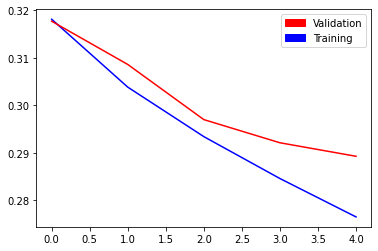

# EPOCH 6 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 7 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 8 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


# EPOCH 9 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.44it/s]


# EPOCH 10 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


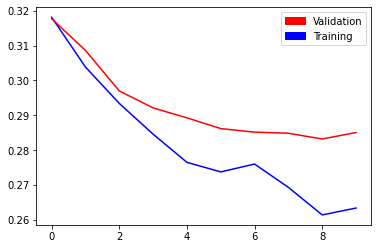

# EPOCH 11 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 12 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 13 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 14 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 15 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


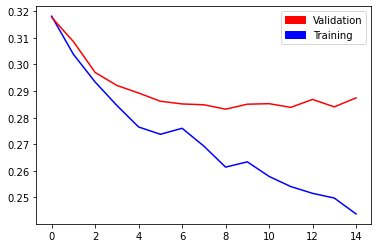

# EPOCH 16 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 17 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 18 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 19 / 100


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


# EPOCH 20 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


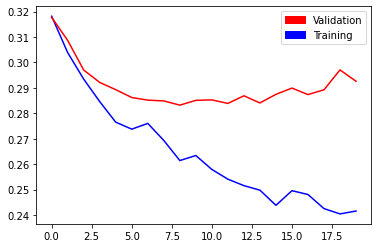

# EPOCH 21 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 22 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


# EPOCH 23 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 24 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 25 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


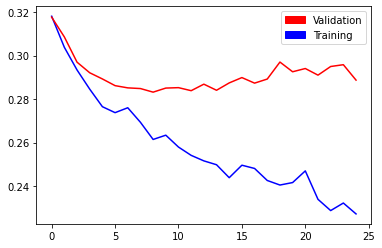

# EPOCH 26 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 27 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


# EPOCH 28 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 29 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 30 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


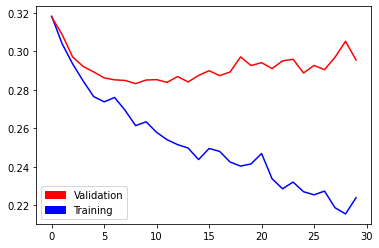

# EPOCH 31 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 32 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.40it/s]


# EPOCH 33 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 34 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 35 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


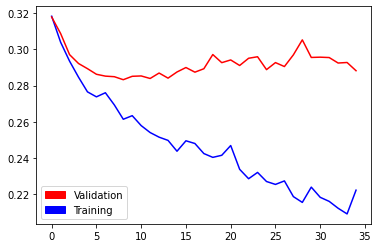

# EPOCH 36 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 37 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 38 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


# EPOCH 39 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 40 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


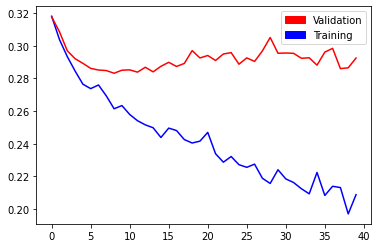

# EPOCH 41 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 42 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 43 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 44 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.39it/s]


# EPOCH 45 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


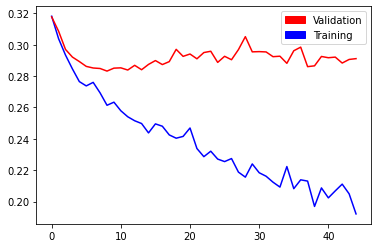

# EPOCH 46 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 47 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 48 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.44it/s]


# EPOCH 49 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 50 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


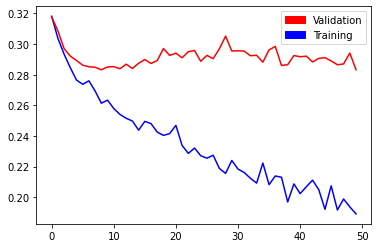

# EPOCH 51 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 52 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 53 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 54 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 55 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


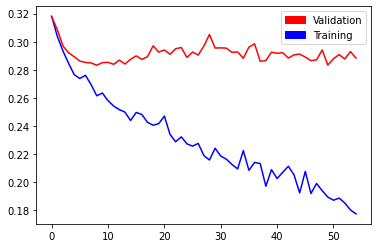

# EPOCH 56 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 57 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 58 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


# EPOCH 59 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.39it/s]


# EPOCH 60 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.39it/s]


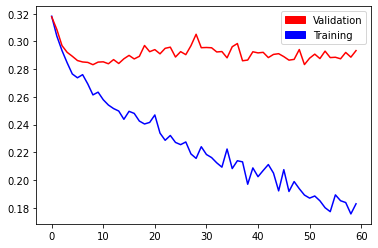

# EPOCH 61 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


# EPOCH 62 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 63 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 64 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 65 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


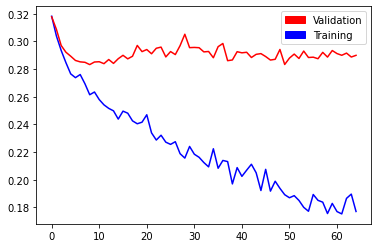

# EPOCH 66 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 67 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 68 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


# EPOCH 69 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


# EPOCH 70 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


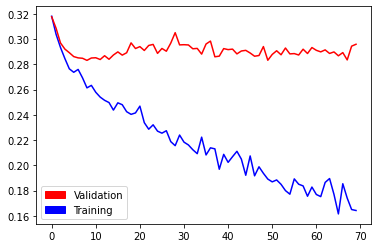

# EPOCH 71 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 72 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 73 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 74 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 75 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


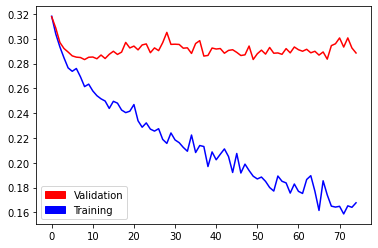

# EPOCH 76 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 77 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


# EPOCH 78 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 79 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 80 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


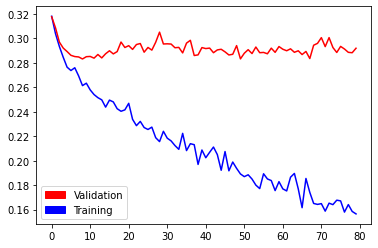

# EPOCH 81 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 82 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 83 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 84 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 85 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


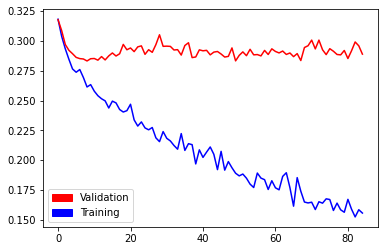

# EPOCH 86 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 87 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


# EPOCH 88 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 89 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.40it/s]


# EPOCH 90 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.44it/s]


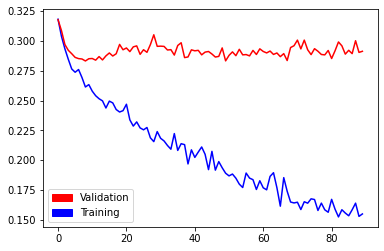

# EPOCH 91 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 92 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


# EPOCH 93 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


# EPOCH 94 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.40it/s]


# EPOCH 95 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


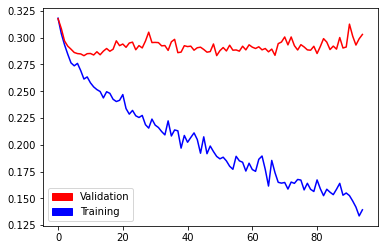

# EPOCH 96 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 97 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.44it/s]


# EPOCH 98 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 99 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


# EPOCH 100 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.40it/s]


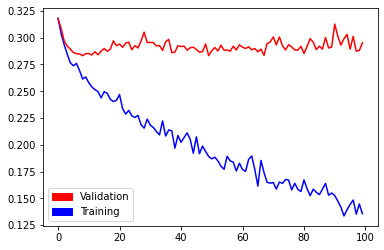

train_mae,█▇▆▆▅▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
train_mse,█▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁
train_pearson,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train_spearman,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███████
valid_mae,█▅▄▃▃▃▃▄▄▅▃▄▃▅▂▂▃▄▂▄▂▄▂▁▃▂▄▃▃▄▂▃▂▄▂▄▇▅▆▄
valid_mse,█▄▁▁▁▁▂▂▃▃▃▄▃▃▃▁▂▂▂▃▂▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▅▄▄▃
valid_pearson,▁▆▇▇▇▇▇▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇█▇▇██▇▇▇▇█▇▇▇██▇██
valid_spearman,▁▂▄▄▄▄▅▅▆▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇██████▇██
train_mae,0.24043
train_mse,0.13569
train_pearson,0.76581


In [71]:
# V-Net-1
normalization = 'groupnorm'
blocknum = 1
avg_pool = 3
dropout_rate = 0.
optim_class = optim.AdamW
lds = False
fds = False
start_update = 0

weight_filename = 'pretrained/230619_vnet-{}'.format(blocknum)
if lds:
    weight_filename += '+lds'
if fds:
    weight_filename += '+fds'

### VNet pretrained model 가져오기
set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // avg_pool
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best3'.format(blocknum, img_size)), strict=False)
net.cuda()

### Parameter freeze X
#     for i, [name, param] in enumerate(net.named_parameters()):
#         if 'encoder' in name:
#             param.requires_grad = False

### W&B 설정
wandb.init(
    project='202305-WMHvolPredRunAll',
    config={"model": "VNet-{}".format(blocknum),
            "lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
            "dropout": dropout_rate,
            "fds": fds, "lds": lds},
    notes='run test')
wandb.watch(net)

### 학습 시작
train_losses = []
validation_losses = []
min_valid_loss = 1.0

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
    augment = get_augmentation_transform()
    train_set.transform = tio.transforms.Compose([preprocess, augment])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    print('# EPOCH %d / %d'%(epoch+1, num_epochs))

    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if min_valid_loss > valid_mse:
        min_valid_loss = valid_mse
        torch.save(net.state_dict(), weight_filename)

    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if (epoch+1)%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()

---

In [72]:
# # 이미지 리샘플링
# image_dir = './input_nifti/'
# label_dir = './input_nifti_seg/'
#     # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
# filenames = sorted(os.listdir(label_dir))
# # print(filenames)

# new_image_dir = './input_nifti_sizematch/'
# new_label_dir = './input_nifti_seg_sizematch/'
# if not os.path.isdir(new_image_dir):
#     os.mkdir(new_image_dir)
# if not os.path.isdir(new_label_dir):
#     os.mkdir(new_label_dir)
    
# transforms = tio.ToCanonical(), tio.Resample(1)
# transform = tio.Compose(transforms)

# for filename in filenames:
# #     img = nib.load(image_dir + filename)
# #     label = nib.load(label_dir + filename)
    
# #     img_data = img.get_fdata()
# #     label_data = label.get_fdata()
    
#     subject = tio.Subject(
#         img = tio.ScalarImage(image_dir + filename),
#         label = tio.LabelMap(label_dir + filename)
#     )
#     transformed = transform(subject)
#     print(transformed.img)
#     print(transformed.label)
#     img = transformed.img.numpy()
#     label = transformed.label.numpy()
    
#     plt.imshow(rotate(np.max(label[0], axis=1), 90), cmap='gray')
#     plt.show()
    
#     # save as nib
#     nifti_img = nib.Nifti1Image(img[0], affine=np.eye(4))
#     nib.save(nifti_img, new_image_dir + filename)
    
#     nifti_label = nib.Nifti1Image(label[0], affine=np.eye(4))
#     nib.save(nifti_label, new_label_dir + filename)

In [73]:
# # 이미지 리샘플링
# image_dir = './input_nifti/'
#     # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
# filenames = sorted(os.listdir(image_dir))[1:]
# print(filenames)

# new_image_dir = './input_nifti_sizematch/'
    
# transforms = tio.ToCanonical(), tio.Resample(1)
# transform = tio.Compose(transforms)

# for filename in filenames:
#     if os.path.isfile(new_image_dir + filename):
#         continue
    
#     subject = tio.Subject(
#         img = tio.ScalarImage(image_dir + filename),
#     )
#     transformed = transform(subject)
#     print(transformed.img)
#     img = transformed.img.numpy()
        
#     # save as nib
#     nifti_img = nib.Nifti1Image(img[0], affine=np.eye(4))
#     nib.save(nifti_img, new_image_dir + filename)

In [74]:
# # 이미지 리샘플링
# image_dir = './test_nifti/'
#     # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
# filenames = sorted(os.listdir(image_dir))
# # print(filenames)

# new_image_dir = './input_nifti_sizematch/'
    
# transforms = tio.ToCanonical(), tio.Resample(1)
# transform = tio.Compose(transforms)

# for filename in filenames:
#     if os.path.isfile(new_image_dir + filename):
#         continue
    
#     subject = tio.Subject(
#         img = tio.ScalarImage(image_dir + filename),
#     )
#     transformed = transform(subject)
#     print(transformed.img)
#     img = transformed.img.numpy()
        
#     # save as nib
#     nifti_img = nib.Nifti1Image(img[0], affine=np.eye(4))
#     nib.save(nifti_img, new_image_dir + filename)